# Анализ A/A/B-теста

<b>Предисловие</b> - в мобильное приложение по продаже продуктов питания хотят внедрить новый шрифт, был проведен A/A/B-тест, чтобы понять повлияет ли изменение шрифтов на пользователей.

<b>Цель исследования</b> - проанализировать результы A/A/B-теста с целью принятия решения по рациональности внедрения новых шрифтов в мобильное приложение. 

<b>Задачи в рамках исследования:</b>
- исследовать исходные данные;
- выполнить предобработку данных;
- изучить данные, наполненность данных по времени;
- изучить воронку событий;
- проанализировать результаты A/A/B-тестирования;
- сформировать итоговые выводы исследования.

<b>Исходные данные для исследования:</b>
- A/A/B-тест по событиям.

<div align='right'>Проектную работу выполнил студент Гагиев Денис. </div>

---

## Общее изучение информации

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
import math as mth
from scipy import stats as st
import matplotlib.pyplot as plt
import plotly.express as px
from plotly import graph_objects as go

In [2]:
# создание датафрейма
try:
    data = pd.read_csv('/Users/dendon/Desktop/Обучение/YP/Конспекты/Сборный проект 2/logs_exp.csv', sep = '\t')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/logs_exp.csv', sep = '\t')

In [3]:
# вывод информации
display(data.head())
data.info()
data['EventName'].value_counts()
data['ExpId'].value_counts()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


248    85747
246    80304
247    78075
Name: ExpId, dtype: int64

**Комментарий:** каждая запись в датафрейме - это действие пользователя. Всего 5 типов событий и 3 экспериментальные группы (ExpId), где 246 и 247 группы контрольные со старыми шрифтами, а 248 - экспериментальная с новыми шрифтами.  Первичное наблюдение говорит об отсутствии пропусков в данных.   
Структура датафрейма следующая:
- EventName — название события;
- DeviceIDHash — уникальный идентификатор пользователя;
- EventTimestamp — время события;
- ExpId — номер группы

## Предобработка данных

In [4]:
# изменяем названия столбцов
data = data.rename(columns={
    'EventName': 'event_name',
    'DeviceIDHash': 'device_id',
    'EventTimestamp': 'event_time',
    'ExpId': 'group_id'})

# изменяем формат данных в event_time
data['event_time'] = pd.to_datetime(data['event_time'], unit='s')

# создаем date с датой
data['date'] = data['event_time'].astype('datetime64[D]')

# поиск дубликатов данных
data.duplicated().sum()
data = data.drop_duplicates()

**Комментарий:** на этапе предобработки данных были:
- изменены названия столбцов;
- изменен формат данных в столбце с датой;
- создан дополнительный столбец только с датой;
- найдены и удалены дубликаты в данных.

Всего было найдено 416 дубликатов, что в соотношении всего датафрейма не критично в случаи их удаления.

## Изучение и проверка данных

In [5]:
display('Всего событий в логе: {}, всего пользователей: {}, в среднем событий на пользователя: {}'.format(
    # подсчет событий в логе
    data.shape[0],
    # подсчет пользователей
    data['device_id'].nunique(),
    # подсчет среднего колличества событий на пользователя
    round(data.shape[0] / data['device_id'].nunique())
))

'Всего событий в логе: 243713, всего пользователей: 7551, в среднем событий на пользователя: 32'

'Данные в датафрейме представлены с 2019-07-25 по 2019-08-07'

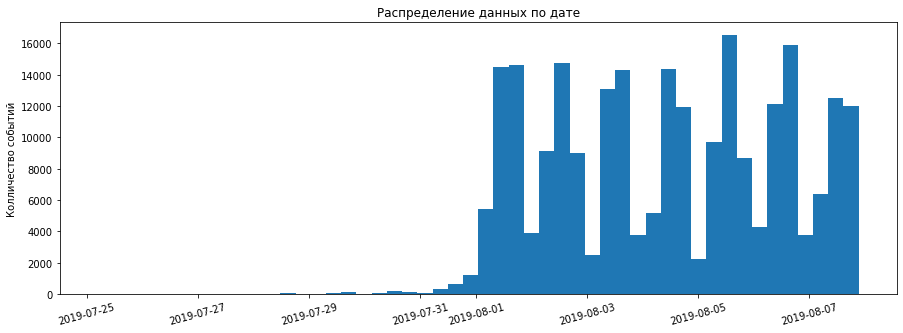

In [6]:
# вывод периода данных
display('Данные в датафрейме представлены с {} по {}'.format(
    data['event_time'].dt.date.min(),
    data['event_time'].dt.date.max()
))

# построение гистограммы распределения данных по дате
plt.figure(figsize = (15, 5))
plt.title('Распределение данных по дате')
plt.hist(data['event_time'], bins = 50)
plt.xticks(rotation=15)
plt.ylabel('Колличество событий')
plt.show()

**Комментарий:** располагаем данными с 2019-07-25 по 2019-08-07. Четко видно, что данные "перекошены", это может быть связанно с технической особенностью - логи некоторых пользовать доходят со временем.  
Данные с 2019-07-25 по 2019-07-31 явно не полные, дальнейшей временной отрезок теста достаточно полный, именно он и будет взят для анализа.

Сделаем срез данные и оставим данные только после 2019-08-01. А также посмотрим как изменилось колличество наблюдений и пользователей, проверим остались ли пользователи во всех 3-х рассматриваемых группах эксперимента.

In [7]:
# выведем данные до очистки
display(
    'Колличество событий до среза данных: {}, колличество пользователей до среза данных: {}'.format(
    data.shape[0], data['device_id'].nunique()))

# сделаем срез данных
data = data[data['event_time'] > '2019-08-01']

# выведем данные после очистки
display(
    'Колличество событий после среза данных: {}, колличество пользователей после среза данных: {}'.format(
    data.shape[0], data['device_id'].nunique()))

display(
    'Потеряно событий после очистки: {}, потеряно пользователей после очистики: {}'.format(
    243713 - 240887, 7551-7534))

'Колличество событий до среза данных: 243713, колличество пользователей до среза данных: 7551'

'Колличество событий после среза данных: 240887, колличество пользователей после среза данных: 7534'

'Потеряно событий после очистки: 2826, потеряно пользователей после очистики: 17'

In [8]:
# проверим не отсеяли ли мы значительно какую-либо из групп
data.groupby(by='group_id').agg(device_unique = ('device_id', 'nunique')).reset_index()

,group_id,device_unique
0,246,2484
1,247,2513
2,248,2537


**Комментарий:** во всех 3-х группах примерно одинаковое колличество уникальных пользователей, эксперимент не будет искажен после очистики данных по дате.

## Анализ воронки событий

Посмотрим на частоту отдельных событий:

In [9]:
# группируем данные по событию
(data.groupby(by='event_name').agg(device_cnt = ('device_id', 'count'))
     .sort_values('device_cnt', ascending=False)
     .reset_index())

,event_name,device_cnt
0,MainScreenAppear,117328
1,OffersScreenAppear,46333
2,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


**Комментарий:** рассмотрим каждое событие по отдельности:  
- MainScreenAppear - 117328 раз пользователи увидели главный экран;
- OffersScreenAppear - 46333 раз пользователи увидели страницу с предложениями;
- CartScreenAppear - 42303 раз пользователи увидели карточку товара;
- PaymentScreenSuccessful - 33918 раз пользователи увидели экран успешной оплаты;
- Tutorial - 1005 раз пользователи увидели обучение.

Теперь посмотрим как много уникальных пользователей совершили отдельное событие:

In [10]:
# группируем по событию и уникальным пользователям
event_by_device = (data.groupby(by='event_name').agg(device_unique = ('device_id', 'nunique'))
     .sort_values(by='device_unique', ascending=False)
     .reset_index())
event_by_device['%'] = event_by_device['device_unique'] / data['device_id'].nunique() * 100
event_by_device['%'] = round(event_by_device['%'], 1)
event_by_device

,event_name,device_unique,%
0,MainScreenAppear,7419,98.5
1,OffersScreenAppear,4593,61.0
2,CartScreenAppear,3734,49.6
3,PaymentScreenSuccessful,3539,47.0
4,Tutorial,840,11.1


**Комментарий:** и вновь рассмотрим события:  
- MainScreenAppear - 98% от общего числа уникальных пользователей увидели главную страницу;
- OffersScreenAppear - 61% от общего числа уникальных пользователей увидели страницу с предложениями;
- CartScreenAppear - 49% от общего числа уникальных пользователей увидели карточку товара;
- PaymentScreenSuccessful - 47% от общего числа уникальных пользователей увидели экран успешной оплаты;
- Tutorial - 11% от общего числа уникальных пользователей увидели обучение.  

То, что главную страницу увидели не все 100% пользователей скорее всего говорит о том, что люди возможно просто переходили сразу в карточку товара через ссылку, ведущую в приложение. Только 11% пользователей увидели обучение, скорее всего в большинстве случаев оно просто не нужно.

События явно складываются в следующем порядке, сначала пользователь попадает на **главную страницу**, далее **изучает предложения**, посещает **карточку конкретного товара** и **видит экран успешной оплаты**. Событие Tutorial не укладывается в цепочке, ведущей к покупке и служит скорее событием к которому обращаются по необходимости.  
Очистим датафрейм от события Tutorial:

In [11]:
# уберем не нужное событие
data = data[data['event_name'] != 'Tutorial']

In [12]:
print('Посетили главную страницу -', '{:.0%}'
      .format(event_by_device['device_unique'][0] / event_by_device['device_unique'][0]),
      '({} пользователей)'.format(event_by_device['device_unique'][0]))

print('Далее перешли на страницу с предложениями -',
      '{:.1%}'.format(event_by_device['device_unique'][1] / event_by_device['device_unique'][0]),
      '({} пользователей)'.format( event_by_device['device_unique'][1]))

print('Далее перешли на страницу в карточку товара -',
      '{:.1%}'.format(event_by_device['device_unique'][2] / event_by_device['device_unique'][1]),
      '({} пользователей)'.format( event_by_device['device_unique'][2]))

print('Успешно оплатили -',
      '{:.1%}'.format(event_by_device['device_unique'][3] / event_by_device['device_unique'][2]),
      '({} пользователей)'.format( event_by_device['device_unique'][3]))

print('От первого события до оплаты доходит -',
      '{:.1%}'.format(event_by_device['device_unique'][3] / event_by_device['device_unique'][0]))

Посетили главную страницу - 100% (7419 пользователей)
Далее перешли на страницу с предложениями - 61.9% (4593 пользователей)
Далее перешли на страницу в карточку товара - 81.3% (3734 пользователей)
Успешно оплатили - 94.8% (3539 пользователей)
От первого события до оплаты доходит - 47.7%


**Комментарий:** больше всего пользователей отпадает после посещения главной страницы на событии просмотра страницы с предложениями, а то есть только 62% пользователей переходят в коталог. От первого события до оплаты доходит - 47.7%

## Анализ результатов эксперимента

Посмотрим сколько пользователей в каждой экспериментальной группе:

In [13]:
# группируем по группам
data.groupby(by='group_id').agg(user_unique = ('device_id', 'nunique'))

,user_unique
group_id,
246,2483
247,2512
248,2535


**Комментарий:** в 246 и 247 группе со старыми шрифтами по 2484 и 2513 уникальных пользователей, в 248 группе с новыми шрифтами 2537 уникальных пользователей.

Перед A/A тестом проверим пересикаются ли пользователи в группах:

In [14]:
data.groupby('device_id')['group_id'].nunique().reset_index().query('group_id > 1').count()

device_id    0
group_id     0
dtype: int64

В первую очередь необходимо произвести анализ A/A теста, который даст нам понять будет ли корректно проводить A/B тест. По первичным критериям мы такой тест провести можем - колличество пользователей в группах практически не различается, пользователи не пересикаются по группам.  
Определим, находят ли статистическую критерии разницу между A A группами, для этого построим функцию, которую будем использовать и далее:

In [15]:
# создадим функцию, куда будем помещать 2 выборки, название события и уровень стат. значимости
# создавать функцию мы будем под двусторонний тест, поскольку в будущих гипотезах колличество пользователей может отличаться
# как в большую, так и меньшую сторону
def stat_test(data_one, data_two, event_name, alpha):
    
    # посчитаем пользователей в обоих выборках
    count_device = np.asarray([data_one['device_id'].nunique(), data_two['device_id'].nunique()])

    # посчитаем пользователей активных по событию
    count_act_device = np.asarray(
        [data_one.loc[data_one['event_name'] == event_name, 'device_id'].nunique(),
         data_two.loc[data_two['event_name'] == event_name, 'device_id'].nunique()])
    
    p1 = count_act_device[0] / count_device[0]
    p2 = count_act_device[1] / count_device[1]
    p_combined = (count_act_device[0] + count_act_device[1]) / (count_device[0] + count_device[1])
    difference = p1 - p2
    
    # подсчет числа стандартных отклонений от среднего значения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/count_device[0] + 1/count_device[1]))
    
    # стандартное нормальное распределение
    distr = st.norm(0, 1)
    
    # поправка Шидака
#     sh_alpha = 1 - (1 - aplha)**(1/16)
    
    # расчет p_value под двусторонний тест
    p_value = (1 - distr.cdf(abs(z_value))) * 2
        
    print('Имя события: {}, p_value: {}'.format(event_name, p_value))    
    
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу, есть значимые различия')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет значимых различий')

Можем приступать к анализу A/A теста между 246 и 247 группами, мы и так знаем, что самое популярное событие - это посещение главной страницы, поэтому можем сразу перебрать все события.

Сформулируем нулевую и альтернативную гипотезу: 
- **Нулевая:** различий в колличестве уникальных пользователей по событию нет
- **Альтернативная:** различия в колличестве уникальных пользователей по событию есть

In [16]:
for name in data['event_name'].unique():
    stat_test(data[data['group_id'] == 246], data[data['group_id'] == 247], name, alpha = 0.05)
    print()

Имя события: MainScreenAppear, p_value: 0.7526703436483038
Не получилось отвергнуть нулевую гипотезу, нет значимых различий

Имя события: OffersScreenAppear, p_value: 0.24786096925282264
Не получилось отвергнуть нулевую гипотезу, нет значимых различий

Имя события: CartScreenAppear, p_value: 0.22867643757335676
Не получилось отвергнуть нулевую гипотезу, нет значимых различий

Имя события: PaymentScreenSuccessful, p_value: 0.11446627829276612
Не получилось отвергнуть нулевую гипотезу, нет значимых различий



**Комментарий:** в рамках A/A теста различий нет, можно запускать A/B тесты с 248 группой.

<div class="alert alert-success">
<b>Комментарий с комплиментом ревьюера:</b>

Согласен, разбиение по группам работает корректно.
</div>


В рамках технического задания нам необходимо статистически достоверно сравнить обе контрольные группы с экспериментальной и также сравнить объединенные контрольные группы с экспериментальной, учитывая что везде по 4 события, получаем 12 A/B тестов. 

Cравним на стат. разницу контрольную 246 группу и экспериментальную 248 группу:

In [17]:
for name in data['event_name'].unique():
    stat_test(data[data['group_id'] == 246], data[data['group_id'] == 248], name, alpha = 0.05)
    print()

Имя события: MainScreenAppear, p_value: 0.3387114076159288
Не получилось отвергнуть нулевую гипотезу, нет значимых различий

Имя события: OffersScreenAppear, p_value: 0.21442476639710506
Не получилось отвергнуть нулевую гипотезу, нет значимых различий

Имя события: CartScreenAppear, p_value: 0.08067367598823139
Не получилось отвергнуть нулевую гипотезу, нет значимых различий

Имя события: PaymentScreenSuccessful, p_value: 0.21693033984516674
Не получилось отвергнуть нулевую гипотезу, нет значимых различий



**Комментарий:** стат. знач. разницы между группами нет.

Cравним на стат. разницу контрольную 247 группу и экспериментальную 248 группу:

In [18]:
for name in data['event_name'].unique():
    stat_test(data[data['group_id'] == 247], data[data['group_id'] == 248], name, alpha = 0.05)
    print()

Имя события: MainScreenAppear, p_value: 0.5194964354051703
Не получилось отвергнуть нулевую гипотезу, нет значимых различий

Имя события: OffersScreenAppear, p_value: 0.9333751305879443
Не получилось отвергнуть нулевую гипотезу, нет значимых различий

Имя события: CartScreenAppear, p_value: 0.5878284605111943
Не получилось отвергнуть нулевую гипотезу, нет значимых различий

Имя события: PaymentScreenSuccessful, p_value: 0.7275718682261119
Не получилось отвергнуть нулевую гипотезу, нет значимых различий



**Комментарий:** стат. знач. разницы между группами нет.

Объеденим контрольные 246 и 247 группы и сравним с 248 группой:

In [19]:
for name in data['event_name'].unique():
    stat_test(data[data['group_id'] != 248], data[data['group_id'] == 248], name, alpha = 0.05)
    print()

Имя события: MainScreenAppear, p_value: 0.3486684291093256
Не получилось отвергнуть нулевую гипотезу, нет значимых различий

Имя события: OffersScreenAppear, p_value: 0.44582745409482394
Не получилось отвергнуть нулевую гипотезу, нет значимых различий

Имя события: CartScreenAppear, p_value: 0.18683558686831558
Не получилось отвергнуть нулевую гипотезу, нет значимых различий

Имя события: PaymentScreenSuccessful, p_value: 0.6107918742187335
Не получилось отвергнуть нулевую гипотезу, нет значимых различий



**Комментарий:** между объединенными контрольными и экспериментальной группой также нет статистически значимой разницы.

При проверке гипотез был выбран уровень статистической значимости равный 5%, было проведено 4 проверки гипотезы в рамках A/A и 12 проверок гипотезы A/B теста. Я бы не изменял уровень стас. значимости поскольку значения p_value слишком высокие и поправки скорее всего не имеют смысла.

<div class="alert alert-success">
<b>Комментарий с комплиментом ревьюера:</b>
    
Гипотезы проверены верно, молодец.
</div>


<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
     
**Заключение по анализу A/A/B-теста**
---
**Обзор проделанной работы:**
- достигнута цель исследования, сформированно рациональное решение по принятию шрифтов;
- проведена предобработка данных исходного массива данных;
- углубленно изучены данные, их наполненность по времени;
- сформированна воронка событий;
- расчитанна статистическая значимость групп теста.

---
**Предобработка данных:**  
- изменены названия столбцов;
- изменен формат данных в столбце с датой;
- создан дополнительный столбец только с датой;
- найдены и удалены дубликаты в данных. 
  
---
**Анализ информации и событий:**  
В рамках изучения данных и формировании воронки событий обнаруженно, что данные наполнены только с 2019-08-01, а событие 'Tutorial' не относится к циклу покупки, поэтому анализ эксперимент производил со срезом данных по дате и событиям.
    
       
---
**Анализ A/A/B-теста:**  
- в рамках A/A теста между 246 и 247 группами статистически значимых различий нет;
- в рамках A/B теста между 246 и 248, 247 и 248, (246+247) и 248 группами статистически значимых различий нет
Значения p_value везде достаточно высокие, это говорит о том, что распределение наблюдений очень близкое друг к другу.

**Итоговый вывод**:  
Статистически разница с внедрением новых шрифтов не обнаружена, скорее всего новый шрифт на влияет значительно на пользователей. 
</div>


<div class="alert alert-success">
<b>Комментарий с комплиментом ревьюера:</b> 
    
Хороший аналитический вывод, который можно предоставить менеджерам. Верно, изменение шрифтов никак не повлияло на поведение пользователей.

</div>
